## This new version is after bug fixed in 
https://github.com/SaeedGhoorchian/costly_nonstationary_bandits/commit/7db1aa2906dd9e88cc0dbfe93d4b5d07f4eea3dc

This had to do with how SimOOS works so we need to retune it.

# Tune the algorithms designed for stationary environments

In this notebook I tune the hyper parameters of those algorithms that were designed to work in stationary environments. These include: Epsilon-greedy, UCB1, LinUCB and SimOOS

For this I run them on the tuning set that includes random 2630 points of the dataset without introducing non-stationarity.
In later experiments i will use the tuned parameters for these algorithms.

Here I use data saved in notebook 20.



In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

## Load data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_tuning.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

## Algorithm evaluation

In [5]:
BETA = 1

In [6]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12960]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

In [7]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.ones(new_rewards.shape)*np.mean(new_rewards, axis=0)

n_arms = all_rewards.shape[1]



In [8]:
new_contexts.shape, new_rewards.shape

((2630, 5), (2630, 3))

### Stationary costs

In [9]:
cost_change_points = []
interval_count = len(cost_change_points) + 1

In [10]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [11]:
interval_means

[array([0.0174908 , 0.02901429, 0.02463988, 0.02197317, 0.01312037])]

In [12]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [13]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

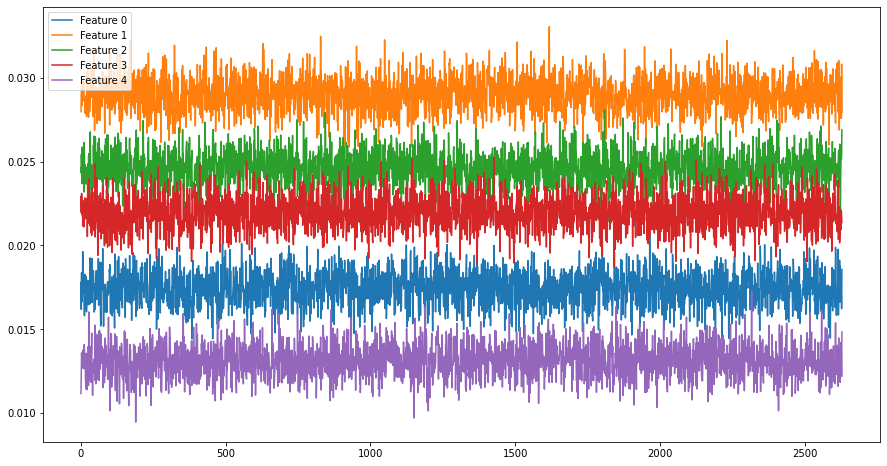

In [14]:
plot_costs(get_costs(), new_contexts.shape[0])

In [15]:
costs_obj = get_costs()

In [16]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [17]:
costs_vector.shape

(2630, 5)

## Plot expected reward

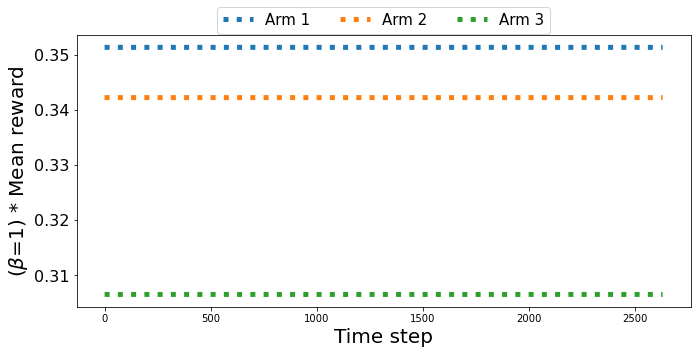

In [18]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)

    
plt.yticks(fontsize=16)
ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


## Plot expected reward minus sum of costs

Min expected gain for arm 1: 0.2374763131826847
Min expected gain for arm 2: 0.2283508378975136
Min expected gain for arm 3: 0.19260939303059343


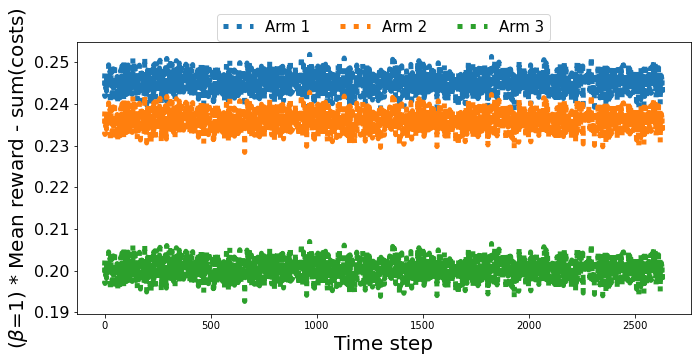

In [19]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")



plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [20]:
data = (new_contexts, new_rewards, costs_vector)

In [21]:
import pickle

with open('dataset/nursery/nursery_tuning_stationary.pickle', 'wb') as f:
    pickle.dump(data, f)

## Testing on non-stationary data

In [20]:
np.random.seed(42)

In [21]:
TUNING_NUM_OF_TRIALS = all_contexts.shape[0]
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

## Epsilon-greedy

In [22]:
egreedy_gains = {}

for eps in [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):
        egreedy = algorithms.EpsilonGreedy(epsilon=eps, n_arms=new_rewards.shape[1])

        gain_egreedy = evaluation.evaluate_on_synthetic_data(
            egreedy,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_egreedy

    gain_egreedy = np.mean(gains, axis=0)
    egreedy_gains[eps] = gain_egreedy

E-greedy(epsilon=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 914.0
	Total reward: 914.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 913.0
	Total reward: 913.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 913.0
	Total reward: 913.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 1109.0
	Total reward: 1109.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 912.0
	Total reward: 912.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 913.0
	Total reward: 913.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Be

In [23]:
last_gains = {k:v[-1] for k,v in egreedy_gains.items()}
best_eps = sorted(last_gains.items(), key=lambda x: x[1])[-1][0];
best_eps

0.03

In [24]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=best_eps, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 971.0
	Total reward: 971.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 1089.0
	Total reward: 1089.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 884.0
	Total reward: 884.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 924.0
	Total reward: 924.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 1028.0
	Total reward: 1028.0
	Total cost: 0
Execution time: 0.0s
Average gain: 979.2


## UCB1

In [25]:
ucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        ucb_alg = algorithms.UCB1(
                n_trials=TUNING_NUM_OF_TRIALS,
                n_arms=new_rewards.shape[1],
                alpha=alpha,
            )

        gain_ucb = evaluation.evaluate_on_synthetic_data(
            ucb_alg,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_ucb

    gain_ucb = np.mean(gains, axis=0)
    ucb_gains[alpha] = gain_ucb

UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.

In [26]:
last_gains = {k:v[-1] for k,v in ucb_gains.items()}
best_alpha_ucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_ucb

0.6

In [27]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=best_alpha_ucb,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
Average gain: 1357.0


## LinUCB

In [28]:
linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        linucb = algorithms.LinUCB(
            n_trials=TUNING_NUM_OF_TRIALS,
            context_dimension=new_contexts.shape[1],
            n_arms=new_rewards.shape[1],
            alpha=alpha,
        )
        gain_linucb = evaluation.evaluate_on_synthetic_data(
            linucb,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_linucb

    gain_linucb = np.mean(gains, axis=0)
    linucb_gains[alpha] = gain_linucb

LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.2s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 1438.7693091283434
	Total reward: 1718.0
	Total cost: 279.23069087165237
Execution time: 0.2s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 1438.7693091283434
	Total reward: 1718.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 1438.7

LinUCB (alpha=0.9)
Beta = 1
Total gain: 1689.769309128344
	Total reward: 1969.0
	Total cost: 279.23069087165237
Execution time: 0.2s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 1689.769309128344
	Total reward: 1969.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 1689.769309128344
	Total reward: 1969.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 1689.769309128344
	Total reward: 1969.0
	Total cost: 279.23069087165237
Execution time: 0.2s


In [29]:
last_gains = {k:v[-1] for k,v in linucb_gains.items()}
best_alpha_linucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_linucb

0.5

In [30]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_linucb,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.2s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.2s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.2s
Average gain: 1723.7693091283431


## SimOOS

In [31]:
simoos_gains = {}


for delta in [0.005, 0.01, 0.03, 0.05, 0.08, 0.09, 0.1, 0.12, 0.16, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        s = time.time()
        p_simoos = algorithms.SimOOSAlgorithm(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta_SimOOS=BETA,
            delta_SimOOS=delta,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_simoos = evaluation.evaluate_on_synthetic_data(
                p_simoos,
                new_contexts[:TUNING_NUM_OF_TRIALS],
                new_rewards[:TUNING_NUM_OF_TRIALS],
                costs_vector[:TUNING_NUM_OF_TRIALS],
                beta=BETA,
                stop_after=TUNING_NUM_OF_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_simoos

    gain_simoos = np.mean(gains, axis=0)
    simoos_gains[delta] = gain_simoos

Took 0.0009541511535644531 seconds
Trial 0, time 2022-05-24 20:59:38.745696
Trial 500, time 2022-05-24 21:00:08.968327
Trial 1000, time 2022-05-24 21:00:15.896136
Trial 1500, time 2022-05-24 21:00:18.208290
Trial 2000, time 2022-05-24 21:00:18.545351
Trial 2500, time 2022-05-24 21:00:20.316272
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 1306.843333525916
	Total reward: 1446.0
	Total cost: 139.15666647408656
Execution time: 41.7s
Took 41.74602007865906 seconds
Took 0.0015559196472167969 seconds
Trial 0, time 2022-05-24 21:00:20.493544
Trial 500, time 2022-05-24 21:00:40.179233
Trial 1000, time 2022-05-24 21:00:40.838592
Trial 1500, time 2022-05-24 21:00:41.074114
Trial 2000, time 2022-05-24 21:00:41.729209
Trial 2500, time 2022-05-24 21:00:54.627512
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 1667.8520120786336
	Total reward: 1813.0
	Total cost: 145.14798792136807
Execution time: 34.9s
Took 34.88782000541687 seconds
Took 0.0017447471618652344 seconds
Trial 0, time 2022-05-24

Trial 2500, time 2022-05-24 21:19:39.458944
SimOOS (beta=1, delta=0.05)
Beta = 1
Total gain: 1294.7699914245638
	Total reward: 1564.0
	Total cost: 269.23000857543457
Execution time: 2.6m
Took 156.22206497192383 seconds
Took 0.001219034194946289 seconds
Trial 0, time 2022-05-24 21:19:40.320899
Trial 500, time 2022-05-24 21:20:08.817271
Trial 1000, time 2022-05-24 21:20:41.331418
Trial 1500, time 2022-05-24 21:21:14.095365
Trial 2000, time 2022-05-24 21:21:22.633871
Trial 2500, time 2022-05-24 21:21:25.423606
SimOOS (beta=1, delta=0.05)
Beta = 1
Total gain: 1468.2665839422598
	Total reward: 1662.0
	Total cost: 193.73341605773965
Execution time: 1.8m
Took 105.1446270942688 seconds
Took 0.0007109642028808594 seconds
Trial 0, time 2022-05-24 21:21:25.465923
Trial 500, time 2022-05-24 21:21:33.841489
Trial 1000, time 2022-05-24 21:21:39.907538
Trial 1500, time 2022-05-24 21:22:08.048362
Trial 2000, time 2022-05-24 21:22:57.166774
Trial 2500, time 2022-05-24 21:23:26.810228
SimOOS (beta=1, de

Trial 500, time 2022-05-24 21:41:14.523482
Trial 1000, time 2022-05-24 21:41:14.973541
Trial 1500, time 2022-05-24 21:42:00.902213
Trial 2000, time 2022-05-24 21:42:42.164853
Trial 2500, time 2022-05-24 21:43:04.346597
SimOOS (beta=1, delta=0.12)
Beta = 1
Total gain: 1494.4188298031263
	Total reward: 1718.0
	Total cost: 223.58117019686972
Execution time: 2.1m
Took 125.75798606872559 seconds
Took 0.0010280609130859375 seconds
Trial 0, time 2022-05-24 21:43:07.018602
Trial 500, time 2022-05-24 21:43:14.192163
Trial 1000, time 2022-05-24 21:43:19.098044
Trial 1500, time 2022-05-24 21:43:53.692837
Trial 2000, time 2022-05-24 21:44:37.413135
Trial 2500, time 2022-05-24 21:45:03.729023
SimOOS (beta=1, delta=0.12)
Beta = 1
Total gain: 1505.3164870550768
	Total reward: 1699.0
	Total cost: 193.68351294492064
Execution time: 2.0m
Took 119.88411593437195 seconds
Took 0.0011730194091796875 seconds
Trial 0, time 2022-05-24 21:45:06.904006
Trial 500, time 2022-05-24 21:45:19.865070
Trial 1000, time 

Trial 500, time 2022-05-24 22:04:05.995985
Trial 1000, time 2022-05-24 22:04:19.784211
Trial 1500, time 2022-05-24 22:04:39.495415
Trial 2000, time 2022-05-24 22:04:40.912102
Trial 2500, time 2022-05-24 22:04:41.844884
SimOOS (beta=1, delta=0.3)
Beta = 1
Total gain: 1279.0642985413483
	Total reward: 1424.0
	Total cost: 144.93570145865021
Execution time: 58.8s
Took 58.83490300178528 seconds
Took 0.002494335174560547 seconds
Trial 0, time 2022-05-24 22:04:42.177265
Trial 500, time 2022-05-24 22:05:07.711082
Trial 1000, time 2022-05-24 22:05:34.928305
Trial 1500, time 2022-05-24 22:05:37.434814
Trial 2000, time 2022-05-24 22:05:57.014275
Trial 2500, time 2022-05-24 22:05:57.631129
SimOOS (beta=1, delta=0.3)
Beta = 1
Total gain: 1275.1863008767682
	Total reward: 1444.0
	Total cost: 168.81369912323126
Execution time: 1.3m
Took 75.49305772781372 seconds
Took 0.0011630058288574219 seconds
Trial 0, time 2022-05-24 22:05:57.672645
Trial 500, time 2022-05-24 22:06:37.041568
Trial 1000, time 2022

Trial 500, time 2022-05-24 22:26:33.630324
Trial 1000, time 2022-05-24 22:26:43.856336
Trial 1500, time 2022-05-24 22:27:16.367421
Trial 2000, time 2022-05-24 22:27:26.039672
Trial 2500, time 2022-05-24 22:27:27.432744
SimOOS (beta=1, delta=0.7)
Beta = 1
Total gain: 1324.7197819280516
	Total reward: 1527.0
	Total cost: 202.28021807194764
Execution time: 1.6m
Took 95.59563899040222 seconds
Took 0.001165628433227539 seconds
Trial 0, time 2022-05-24 22:27:27.569371
Trial 500, time 2022-05-24 22:27:46.563711
Trial 1000, time 2022-05-24 22:27:47.062990
Trial 1500, time 2022-05-24 22:27:47.956056
Trial 2000, time 2022-05-24 22:27:53.823839
Trial 2500, time 2022-05-24 22:27:54.127374
SimOOS (beta=1, delta=0.7)
Beta = 1
Total gain: 1594.0905436309765
	Total reward: 1724.0
	Total cost: 129.90945636902217
Execution time: 26.6s
Took 26.588752269744873 seconds
Took 0.00078582763671875 seconds
Trial 0, time 2022-05-24 22:27:54.158965
Trial 500, time 2022-05-24 22:28:30.518143
Trial 1000, time 2022-

Trial 500, time 2022-05-24 22:47:08.037901
Trial 1000, time 2022-05-24 22:47:29.934761
Trial 1500, time 2022-05-24 22:47:31.791839
Trial 2000, time 2022-05-24 22:47:32.073708
Trial 2500, time 2022-05-24 22:47:32.359577
SimOOS (beta=1, delta=0.99)
Beta = 1
Total gain: 1610.0138183252332
	Total reward: 1824.0
	Total cost: 213.9861816747636
Execution time: 42.7s
Took 42.73347473144531 seconds


In [32]:
last_gains = {k:v[-1] for k,v in simoos_gains.items()}
best_delta_simoos  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_delta_simoos

0.8

In [33]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=best_delta_simoos,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0016121864318847656 seconds
Trial 0, time 2022-05-24 22:47:33.567139
Trial 500, time 2022-05-24 22:47:44.015970
Trial 1000, time 2022-05-24 22:47:48.895582
Trial 1500, time 2022-05-24 22:48:13.271462
Trial 2000, time 2022-05-24 22:48:20.852647
Trial 2500, time 2022-05-24 22:48:21.635876
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 1289.0136083885611
	Total reward: 1426.0
	Total cost: 136.98639161143885
Execution time: 48.2s
Took 48.223994970321655 seconds
Took 0.0018129348754882812 seconds
Trial 0, time 2022-05-24 22:48:21.793191
Trial 500, time 2022-05-24 22:48:34.418042
Trial 1000, time 2022-05-24 22:48:42.307596
Trial 1500, time 2022-05-24 22:49:09.104840
Trial 2000, time 2022-05-24 22:49:18.044440
Trial 2500, time 2022-05-24 22:49:19.071397
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 1756.2208260827529
	Total reward: 1918.0
	Total cost: 161.77917391724932
Execution time: 57.4s
Took 57.350690841674805 seconds
Took 0.0007688999176025391 seconds
Trial 0, time 2022-05-24 

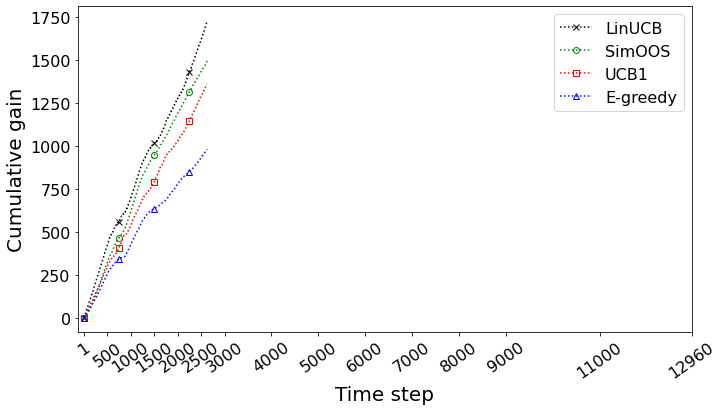

In [34]:
plot_gains({
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'SimOOS': gain_simoos,
},
)


In [35]:
best_eps # Epsilon-greedy

0.03

In [36]:
best_alpha_ucb # UCB1

0.6

In [37]:
best_alpha_linucb # LinUCB

0.5

In [38]:
best_delta_simoos # SimOOS

0.8